# Datacenter anomaly detection

In this problem, you are going to build a model, which finds anomalies in the behavior of virtual machines in the datacenter.

We have collected for you a number of logs on VMs (actually, the dataset is a real data from a real datacenter). The logs are CPU load and memory load (RAM) for every VM. Your goal is to build a system detecting abnormal behavior of the VMs so that the system administrator can notice them and pay attention.

The data and Jupyter notebook file with some pre-defined code for you can be found in the folder datacenter.

Take a look at <b>system-load.csv</b>. This is a raw data file, partially preprocessed for you. You can open in in any text editor or table editor such as Excel. CSV is one of the most popular data format files, you will often use in in your study and at work. It is worth to investigate how it looks in details.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from matplotlib.patches import Ellipse

In [7]:
%matplotlib inline

## Initialization

Log file with VM usage statistics.

In [8]:
input_filename = "system-load.csv"

Number of Gaussians.

In [9]:
num_gaussians = 3

Convergence threshold.

In [10]:
convergence_eps = 0.01

Random seed.

In [11]:
random_seed = 42

## Loading the data

In [12]:
df_load = pd.read_csv(input_filename)

In [13]:
X = df_load.values

Normalizing the data to the range [0..1].

In [14]:
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [15]:
m, n = X.shape

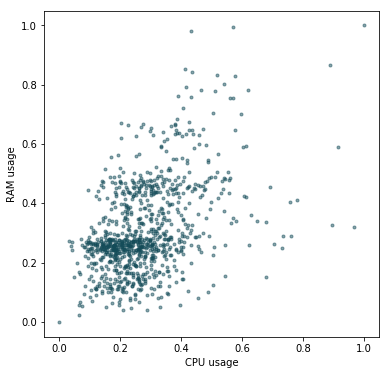

In [16]:
plt.figure(figsize=(6, 6))
plt.plot(X.T[0], X.T[1], "o", c="#144C59", alpha=0.5, markersize=3)

plt.xlabel("CPU usage")
plt.ylabel("RAM usage")
plt.show()

## Training miture of Gaussians

In [17]:
np.random.seed(random_seed)

Initializing Gaussians at random data points.

In [19]:
means = X[np.random.choice(m, size=num_gaussians, replace=False)]

In [20]:
covariances = np.ones((num_gaussians, n, n)) * np.identity(n)

Initializing source probability for every Gaussian.

In [21]:
phis = np.ones(num_gaussians) / num_gaussians

Initializing correspondence probability matrix for every point.

In [22]:
W = np.zeros((num_gaussians, m))

Implement multivariate Gaussian PDF.

In [ ]:
def multivariate_gaussian_pdf(X, mu, sigma):
    # =============== TODO: Your code here ===============
    # Compute the probability density function for the multivariate normal distribution.
    # NOTE: this function should also work when X is a 2D matrix (m x n).
    
    return 0.5
    # ====================================================

Implement E step of EM algorithm.

In [ ]:
def e_step(X, means, covariances, phis):
    num_gaussians = len(means)
    W = np.zeros((num_gaussians, len(X)))
    
    # =============== TODO: Your code here ===============
    # Compute W for each Gaussian.
    
    # ====================================================
        
    return W

Implement M step of EM algorithm.

In [ ]:
def m_step(X, W):
    num_gaussians = len(W)
    m, n = X.shape
    
    phis = np.zeros(num_gaussians)
    means = np.zeros((num_gaussians, n))
    covariances = np.zeros((num_gaussians, n, n))
    
    # =============== TODO: Your code here ===============
    # Compute phi, mean, and covariance for each Gaussian.
    
    # ====================================================
    
    return phis, means, covariances

**Run EM until convergence**

In [ ]:
def gmm_log_likelihood(x, phis, means, covariances, num_gaussians):
    # =============== TODO: Your code here ===============
    # Compute log likelihood of the mixture of Gaussians.
    
    # ====================================================

In [ ]:
log_likelihoods = []

In [ ]:
for iteration in range(max_em_iterations):
    # E-step.
    W = e_step(X, means, covariances, phis)

    # Compute log-likelihood.
    log_likelihood = gmm_log_likelihood(x, phis, means, covariances, num_gaussians)
    log_likelihoods.append(log_likelihood)
    print("Iteration: {0:3d}    Log-likelihood: {1:10.4f}".format(iteration, log_likelihood))

    # M-step.
    phis, means, covariances = m_step(X, W)
    
    # Check log-likelihood for convergence.
    if len(log_likelihoods) > 2 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < convergence_eps:
        print("EM has converged. Stopping early.")
        break

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods)

plt.xlabel("# Iteration")
plt.ylabel("Log-likelihood")
plt.title("Learning Progress")

plt.show()

## Visualizing the results

In [ ]:
def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    width, height = 2 * nstd * np.sqrt(abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [ ]:
def plot_gaussians(X, means, covs, ax=None):
    n = len(means)
    colors = ["#1F77B4", "#2CA02C", "#FFBB78", "#4C529B"]
    
    plt.cla()
    plt.plot(X.T[0], X.T[1], "o", c="#144C59", alpha=0.5, markersize=3)
    
    for k in range(num_gaussians):
        plot_ellipse(means[k], covs[k], ax=ax, alpha=0.4, color=colors[k % len(colors)])

In [ ]:
plt.figure(figsize=(8, 8))
plot_gaussians(X, means, covariances)

plt.xlabel("CPU usage")
plt.ylabel("RAM usage")
plt.show()